# 2025 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

## 0. Setup


In [24]:
from nltk.data import retrieve
!pip install -q tqdm
!pip install -q rank_bm25
!pip install -q sentence-transformers hnswlib
!pip install -U bitsandbytes transformers accelerate


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
  error: subprocess-exited-with-error
  
  exit code: 1
  
  [5 lines of output]
  running bdist_wheel
  running build
  running build_ext
  building 'hnswlib' extension
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for hnswlib

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Failed to build installable wheels for some pyproject.toml based projects (hnswlib)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import os
import re
import gzip 
import json
import torch
import pickle
import hnswlib
import pathlib 
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from rank_bm25 import BM25Okapi
from torch.utils.data import DataLoader
from nltk.tokenize import wordpunct_tokenize
from sentence_transformers import InputExample
from sentence_transformers import CrossEncoder
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

### 0.1 Log in to huggingface

In [26]:
from huggingface_hub import login

login(os.getenv("HUGGING_FACE_API_KEY"))

### 0.2 Check GPU availability

In [27]:
# Make sure CUDA is available
assert torch.cuda.is_available(), "CUDA is not available!"
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 4070 SUPER


# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## DATA COLLECTION

In [28]:
DATA_DIR   = "./data"
TRAIN_FILE = os.path.join(DATA_DIR, "train-claims.json")
DEV_FILE   = os.path.join(DATA_DIR, "dev-claims.json")
TEST_FILE  = os.path.join(DATA_DIR, "test-claims-unlabelled.json")
EVID_FILE  = os.path.join(DATA_DIR, "evidence.json")


def load_claims(path: str, labelled: bool = True) -> pd.DataFrame:
    '''
    Load the claims from the given path.
    Save into dataframes.
    '''
    with open(path, "r", encoding="utf-8") as f:
        raw = json.load(f)

    rows = []
    for cid, info in raw.items():
        row = {
            "claim_id":   cid,
            "claim_text": info.get("claim_text", "")
        }
        if labelled:
            row["label"]      = info["claim_label"]
            row["evid_ids"]   = info["evidences"]
        rows.append(row)

    df = pd.DataFrame(rows)

   
    if labelled:
        df["label"] = df["label"].astype("category")

    return df


def load_evidence(path: str):
    '''
    Load the evidence from the given path.
    Save into dataframes.
    '''
    with open(path, "r", encoding="utf-8") as f:
        raw = json.load(f)

    df   = pd.DataFrame([{"evid_id": k, "evid_text": v} for k, v in raw.items()])
    edict = {k: v for k, v in raw.items()}
    return df, edict



df_train = load_claims(TRAIN_FILE, labelled=True)
df_dev   = load_claims(DEV_FILE,   labelled=True)
df_test  = load_claims(TEST_FILE,  labelled=False)

df_evid, evid_dict = load_evidence(EVID_FILE)    


LABEL2ID = {"SUPPORTS": 0, "REFUTES": 1, "NOT_ENOUGH_INFO": 2, "DISPUTED": 3}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

for df in (df_train, df_dev):
    df["label_id"] = df["label"].map(LABEL2ID).astype("int8")

print(f"Train size: {len(df_train):,}")
print(f"Dev   size: {len(df_dev):,}")
print(f"Test  size: {len(df_test):,}")
print(f"Evidence passages: {len(df_evid):,}")

display(df_train.head())
display(df_evid.head())

print("Train label distribution:")
display(df_train["label"].value_counts())

print("Dev label distribution:")
display(df_dev["label"].value_counts())


Train size: 1,228
Dev   size: 154
Test  size: 153
Evidence passages: 1,208,827


,claim_id,claim_text,label,evid_ids,label_id
0,claim-1937,Not only is there no scientific evidence that ...,DISPUTED,"[evidence-442946, evidence-1194317, evidence-1...",3
1,claim-126,El Niño drove record highs in global temperatu...,REFUTES,"[evidence-338219, evidence-1127398]",1
2,claim-2510,"In 1946, PDO switched to a cool phase.",SUPPORTS,"[evidence-530063, evidence-984887]",0
3,claim-2021,Weather Channel co-founder John Coleman provid...,DISPUTED,"[evidence-1177431, evidence-782448, evidence-5...",3
4,claim-2449,"""January 2008 capped a 12 month period of glob...",NOT_ENOUGH_INFO,"[evidence-1010750, evidence-91661, evidence-72...",2


,evid_id,evid_text
0,evidence-0,"John Bennet Lawes, English entrepreneur and ag..."
1,evidence-1,Lindberg began his professional career at the ...
2,evidence-2,``Boston (Ladies of Cambridge)'' by Vampire We...
3,evidence-3,"Gerald Francis Goyer (born October 20, 1936) w..."
4,evidence-4,He detected abnormalities of oxytocinergic fun...


Train label distribution:


label
SUPPORTS           519
NOT_ENOUGH_INFO    386
REFUTES            199
DISPUTED           124
Name: count, dtype: int64

Dev label distribution:


label
SUPPORTS           68
NOT_ENOUGH_INFO    41
REFUTES            27
DISPUTED           18
Name: count, dtype: int64

In [29]:
CLIMATE_CONCEPTS = {
    "physical_mechanisms": [
        "greenhouse effect", "carbon dioxide", "CO2", "methane", "CH4", 
        "greenhouse gas", "GHG", "emissions", "fossil fuel", "carbon cycle",
        "radiative forcing", "albedo", "feedback", "sensitivity"
    ],
    "observations": [
        "temperature", "warming", "cooling", "precipitation", "sea level", 
        "ice sheet", "glacier", "sea ice", "ocean acidification", "drought",
        "flood", "extreme weather", "heat wave", "storm", "hurricane"
    ],
    "climate_systems": [
        "atmosphere", "ocean", "cryosphere", "biosphere", "El Niño", "La Niña", 
        "jet stream", "gulf stream", "AMOC", "PDO", "AMO", "ENSO", "monsoon"
    ],
    "time_periods": [
        "pre-industrial", "industrial", "holocene", "anthropocene", "pleistocene",
        "ice age", "medieval warm period", "little ice age", "paleoclimate"
    ]
}

## Feature Extraction Phase 1 --> 600
Uses BM25 along with MiniLM to retrieve top 600 most relevant evidences


### BM25

In [30]:
# Top 600 relevant evidences
K_BM25   = 600    
N_DENSE  = 600    
EF_QUERY = 200    

def tokenize(text: str):
    return [tok.lower() for tok in wordpunct_tokenize(text) if tok.isalnum()]


corpus_tokens = [tokenize(t) for t in evid_dict.values()]
bm25          = BM25Okapi(corpus_tokens)
evid_list     = list(evid_dict.keys())         


def get_bm25_topk(df, K=K_BM25):
    # Get cached result if exists
    cache_path = pathlib.Path(f"bm25_top{K}.pkl.gz")
    if cache_path.exists():
        with gzip.open(cache_path, "rb") as f:
            print(f"✓ load BM25 cache ({cache_path})")
            return pickle.load(f)

    # Calculate BM25 scores for each claim
    claim_topk = {}
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"BM25 Top-{K}"):
        idxs = np.argsort(bm25.get_scores(tokenize(row.claim_text)))[::-1][:K]
        claim_topk[row.claim_id] = [evid_list[i] for i in idxs]

    # Save cached result
    with gzip.open(cache_path, "wb") as f:
        pickle.dump(claim_topk, f)
    print(f"⌛ save cache to {cache_path}")
    return claim_topk


bm25_topk = get_bm25_topk(df_dev, K_BM25)

✓ load BM25 cache (bm25_top600.pkl.gz)


### MiniLM

In [31]:
# Load MiniLM sentence transformer model
MODEL = "all-MiniLM-L12-v2"
minilm = SentenceTransformer(MODEL)

# Get embedding dimensionality
DIM = minilm.get_sentence_embedding_dimension()

# Define file paths for HNSW index and evidence ID list
hnsw_bin = pathlib.Path("evidence_hnsw.bin")
ids_npy = pathlib.Path("evid_ids.npy")

# Load evidence IDs
evid_ids = np.load(ids_npy)

# If the HNSW index doesn't exist, build and save it
if not hnsw_bin.exists():
    print("Building hnsw bin...")
    # Encode evidence sentences into dense vectors
    ev_emb = minilm.encode(
        list(evid_dict.values()),
        batch_size=256,
        normalize_embeddings=True,
        show_progress_bar=True
    )

    # Save the list of evidence IDs
    np.save(ids_npy, np.array(evid_list))

    # Create and initialize HNSW index
    idx = hnswlib.Index(space="cosine", dim=DIM)
    idx.init_index(max_elements=len(ev_emb), ef_construction=200, M=32)

    # Add encoded vectors to the index and save it
    idx.add_items(ev_emb)
    idx.save_index(str(hnsw_bin))

# If index file already exists, load it
else:
    print("Loading hnsw bin...")
    idx = hnswlib.Index(space="cosine", dim=DIM)
    idx.load_index(str(hnsw_bin), max_elements=len(evid_ids))
    print("Loaded hnsw bin")

# Set query-time ef parameter for HNSW search
idx.set_ef(EF_QUERY)

# Function to retrieve top-k evidence IDs using MiniLM + HNSW
def dense_retrieve(text, k=N_DENSE):
    # Encode query using both models
    q_vec = minilm.encode(text, normalize_embeddings=True)

    # Search the fused index
    I, _ = idx.knn_query(q_vec, k=k)
    return [evid_ids[i] for i in I[0]]


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\Tom\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Tom\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Building hnsw bin...


Batches:   0%|          | 0/4722 [00:00<?, ?it/s]

### Combine BM25 and MiniLM

In [32]:
# Retrieve top evidence IDs for each claim using union of BM25 and dense
claim_topk = {}
for _, row in tqdm(df_dev.iterrows(), total=len(df_dev), desc="BM25∪HNSW retrieval"):
    # Merge BM25 and dense retrieval results (remove duplicates while preserving order)
    merged = list(dict.fromkeys(
        bm25_topk[row.claim_id] + dense_retrieve(row.claim_text)))
    # Store merged results for the current claim
    claim_topk[row.claim_id] = merged

BM25∪HNSW retrieval:   0%|          | 0/154 [00:00<?, ?it/s]

### Evaluate result

In [33]:
# Function to compute recall@k for development set
def recall_at_k(dev_df, topk_map):
    rs = []
    for _, r in dev_df.iterrows():
        gold = set(r.evid_ids)                            # Ground truth evidence
        found = len(gold & set(topk_map[r.claim_id]))     # Correctly retrieved evidence
        rs.append(found / len(gold))                      # Recall for this claim
    return sum(rs) / len(rs)                              # Average recall

print("Computing recall...")
# Evaluate recall on development set and print result
recall_val = recall_at_k(df_dev, claim_topk)
print(f"\nRecall(BM25∪HNSW) on dev: {recall_val:.3f}")

Computing recall...

Recall(BM25∪HNSW) on dev: 0.843


## Feature Extraction Phase 2 600 -> 200

In [34]:
def simple_tokenize(text):
    
    words = re.findall(r'\w+', text.lower())
    return [w for w in words if len(w) > 3]

def calculate_recall(gold_ids, pred_ids):
    
    if not gold_ids:
        return 1.0
    return len(set(gold_ids) & set(pred_ids)) / len(gold_ids)

def improved_coarse_retrieval(df,
                              evid_dict,
                              bm25: BM25Okapi,
                              evid_list,
                              sbert: SentenceTransformer,
                              hnsw_index: hnswlib.Index,
                              evid_ids,
                              k_bm25=100,
                              k_dense=100,
                              rrf_k=60,
                              mmr_lambda=0.7,
                              candidates_per_claim=200,
                              cache_path="improved_coarse_candidates.pkl.gz"):

    cache_file = pathlib.Path(cache_path)
    if cache_file.exists():
        with gzip.open(cache_file, "rb") as f:
            data = pickle.load(f)
        print(f"✓ load from cache: {cache_file}")
        return data['candidates'], data['recall']
    
    claim_candidates = {}
    recall_vals = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="improved"):
        cid = row['claim_id']
        text = row['claim_text']
        gold = row.get('evid_ids', [])
        
        # 1. BM25
        tokens = simple_tokenize(text)
        bm25_scores = bm25.get_scores(tokens)
        top_bm25 = np.argsort(-bm25_scores)[:k_bm25]
        bm25_ids = [evid_list[i] for i in top_bm25]
        bm25_rank = {evid_list[i]: r for r,i in enumerate(top_bm25)}
        
        # 2. Dense 
        q_emb = sbert.encode(text, normalize_embeddings=True)
        labels, _ = hnsw_index.knn_query(q_emb.reshape(1, -1), k=k_dense)
        dense_idx = labels[0]
        dense_ids = [evid_ids[i] for i in dense_idx]
        dense_rank = {evid_ids[i]: r for r,i in enumerate(dense_idx)}
        
        # 3. RRF
        fusion = {}
        for eid in set(bm25_ids + dense_ids):
            score = 0.0
            if eid in bm25_rank:
                score += 1/(bm25_rank[eid] + rrf_k)
            if eid in dense_rank:
                score += 1/(dense_rank[eid] + rrf_k)
            fusion[eid] = score
        fused = [eid for eid,_ in sorted(fusion.items(), key=lambda x: -x[1])]
        
        # 4. MMR
        pool = fused[:2*candidates_per_claim]
        pool_embs = sbert.encode([evid_dict[e] for e in pool], normalize_embeddings=True)
        sim_q = cosine_similarity(q_emb.reshape(1,-1), pool_embs)[0]
        
        selected, cand_ids, cand_embs = [], pool.copy(), pool_embs.copy()
        sim_to_q = sim_q.copy()
        while len(selected) < candidates_per_claim and cand_ids:
            if not selected:
                idx0 = int(np.argmax(sim_to_q))
            else:
                sims = cosine_similarity(q_emb.reshape(1,-1), cand_embs)[0]
                sel_embs = sbert.encode([evid_dict[e] for e in selected], normalize_embeddings=True)
                sim_sel = cosine_similarity(cand_embs, sel_embs)
                max_sel = np.max(sim_sel, axis=1)
                mmr_scores = mmr_lambda * sims - (1-mmr_lambda) * max_sel
                idx0 = int(np.argmax(mmr_scores))
            selected.append(cand_ids.pop(idx0))
            cand_embs = np.delete(cand_embs, idx0, axis=0)
            sim_to_q = np.delete(sim_to_q, idx0)
        
        claim_candidates[cid] = selected
        recall_vals.append(calculate_recall(gold, selected))
    
    mean_rec = float(np.mean(recall_vals))
    
    with gzip.open(cache_file, "wb") as f:
        pickle.dump({'candidates': claim_candidates, 'recall': mean_rec}, f)
    print(f"⌛ cache: {cache_file}")
    print(f"average recall : {mean_rec:.4f}  |  candicate: {candidates_per_claim}")
    
   
    print("\n sample:")
    for i, row in df.head(3).iterrows():
        cid = row['claim_id']
        gold = row.get('evid_ids', [])
        found = len(set(gold)&set(claim_candidates[cid]))
        print(f"{cid}: {found}/{len(gold)} = {found/len(gold):.2f}")
    
    return claim_candidates, mean_rec


improved_cands, improved_rec = improved_coarse_retrieval(
    df_dev, evid_dict, bm25, evid_list, minilm, idx, evid_ids,
    k_bm25=100, k_dense=100, rrf_k=60,
    mmr_lambda=0.7, candidates_per_claim=200
)
print(f"\nfinal Recall: {improved_rec:.4f}")


✓ load from cache: improved_coarse_candidates.pkl.gz

final Recall: 0.7158


## Feature Extraction Phase 3 200 -> 10

In [35]:


training_sample = []
for key, evid_ids in improved_cands.items():
    filtered_df = df_dev[df_dev['claim_id'] == key]
    for evid_id in evid_ids:
        relevant = 0
        if str(evid_id) in filtered_df['evid_ids'].values[0]:
            relevant = 1
        training_sample.append(InputExample(texts=[filtered_df["claim_text"].values[0], evid_dict[evid_id]], label=float(relevant)))


In [36]:
print(training_sample[:10])

[<sentence_transformers.readers.InputExample.InputExample object at 0x00000224ADA7AD50>, <sentence_transformers.readers.InputExample.InputExample object at 0x00000224ADA79A10>, <sentence_transformers.readers.InputExample.InputExample object at 0x00000224ADA78650>, <sentence_transformers.readers.InputExample.InputExample object at 0x00000224ADA7B590>, <sentence_transformers.readers.InputExample.InputExample object at 0x00000224ADA78250>, <sentence_transformers.readers.InputExample.InputExample object at 0x00000224ADA7AFD0>, <sentence_transformers.readers.InputExample.InputExample object at 0x00000224ADA7B410>, <sentence_transformers.readers.InputExample.InputExample object at 0x00000224ADA7B650>, <sentence_transformers.readers.InputExample.InputExample object at 0x00000224ADA7B350>, <sentence_transformers.readers.InputExample.InputExample object at 0x00000224ADA78050>]


In [37]:
model_name = "cross-encoder/ms-marco-MiniLM-L6-v2"
model = CrossEncoder(model_name, num_labels=1)


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

C:\Users\Tom\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Tom\.cache\huggingface\hub\models--cross-encoder--ms-marco-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. F

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

In [38]:

dataloader = DataLoader(training_sample, shuffle=True, batch_size=8)



In [39]:
model.fit(
    train_dataloader=dataloader,
    epochs=5,
    warmup_steps=10,
)

Step,Training Loss
500,0.086900
1000,0.069000
1500,0.062800
2000,0.054400
2500,0.059700
3000,0.068100
3500,0.051400
4000,0.041200
4500,0.044600
5000,0.048000


In [40]:
model.save("./cross_encoder_model")

In [60]:


def softmax(x):
    e_x = np.exp(x - np.max(x))  # for numerical stability
    return e_x / e_x.sum()
    

def rerank_with_cross_encoder(claims_df, evid_dict, candidate_map):
    reranked = {}
    for _, row in tqdm(claims_df.iterrows(), total=len(claims_df), desc="Re-ranking"):
        claim_id = row['claim_id']
        claim_text = row['claim_text']
        candidates = candidate_map[claim_id]

        # Prepare input pairs for cross-encoder
        pairs = [(claim_text, evid_dict[eid]) for eid in candidates]
        
        # Predict relevance scores
        scores = model.predict(pairs, batch_size=32)

        reranked[claim_id] = (candidates, scores)
    return reranked


reranked_candidates = rerank_with_cross_encoder(df_dev, evid_dict, improved_cands)


Re-ranking:   0%|          | 0/154 [00:00<?, ?it/s]

In [74]:
EXTRACTION_THRESHOLD = 0.00005

def extract_top_evid(candidates, scores):   
    scores = np.array(scores)
    probs = softmax(scores)
    indices_to_keep = np.where(probs > EXTRACTION_THRESHOLD)[0]
    # Take top-N evidence IDs
    top_evids = [candidates[idx] for idx in indices_to_keep ]
    return top_evids

final_candidates = {}
for claim_id, (candidates, scores) in reranked_candidates.items():
    
    claim_text = df_dev[df_dev['claim_id'] == claim_id]['claim_text'].values[0]
    

    final_candidates[claim_id] = {
        'claim_text': claim_text,
        'evidences': extract_top_evid(candidates, scores)
    }

def precision_recall_f1_at_k(dev_df, topk_map, k=None):
    precisions, recalls, f1s = [], [], []
    
    for _, row in dev_df.iterrows():
        gold = set(row.evid_ids)
        
        pred_data = topk_map.get(row.claim_id, {})
        if isinstance(pred_data, dict):
            pred = pred_data.get('evidences', [])
        else:
            pred = [] 
        
        if k:
            pred = pred[:k]
        
        pred_set = set(pred)
        correct = len(gold & pred_set)
        
        precision = correct / len(pred) if pred else 0.0
        recall = correct / len(gold) if gold else 0.0
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0.0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)
    avg_f1 = sum(f1s) / len(f1s)
    
    return {
        'precision@k': avg_precision,
        'recall@k': avg_recall,
        'f1@k': avg_f1
    }

print(precision_recall_f1_at_k(df_dev, final_candidates))

{'precision@k': 0.8859700905155449, 'recall@k': 0.7059523809523808, 'f1@k': 0.7569189051703525}


In [43]:
df_dev

,claim_id,claim_text,label,evid_ids,label_id
0,claim-752,[South Australia] has the most expensive elect...,SUPPORTS,"[evidence-67732, evidence-572512]",0
1,claim-375,when 3 per cent of total annual global emissio...,NOT_ENOUGH_INFO,"[evidence-996421, evidence-1080858, evidence-2...",2
2,claim-1266,This means that the world is now 1C warmer tha...,SUPPORTS,"[evidence-889933, evidence-694262]",0
3,claim-871,"“As it happens, Zika may also be a good model ...",NOT_ENOUGH_INFO,"[evidence-422399, evidence-702226, evidence-28...",2
4,claim-2164,Greenland has only lost a tiny fraction of its...,REFUTES,"[evidence-52981, evidence-264761, evidence-947...",1
...,...,...,...,...,...
149,claim-2400,"'To suddenly label CO2 as a ""pollutant"" is a d...",REFUTES,"[evidence-409365, evidence-127519, evidence-85...",1
150,claim-204,"after a natural orbitally driven warming, atmo...",NOT_ENOUGH_INFO,"[evidence-368192, evidence-261690, evidence-20...",2
151,claim-1426,Many of the world’s coral reefs are already ba...,NOT_ENOUGH_INFO,"[evidence-1124018, evidence-995813, evidence-1...",2
152,claim-698,A recent study led by Lawrence Livermore Natio...,REFUTES,[evidence-660755],1


In [75]:
final_candidates

{'claim-752': {'claim_text': '[South Australia] has the most expensive electricity in the world.',
  'evidences': ['evidence-67732', 'evidence-572512']},
 'claim-375': {'claim_text': 'when 3 per cent of total annual global emissions of carbon dioxide are from humans and Australia prod\xaduces 1.3 per cent of this 3 per cent, then no amount of emissions reductio\xadn here will have any effect on global climate.',
  'evidences': [np.str_('evidence-699212'), 'evidence-996421']},
 'claim-1266': {'claim_text': 'This means that the world is now 1C warmer than it was in pre-industrial times',
  'evidences': ['evidence-694262', 'evidence-889933']},
 'claim-871': {'claim_text': '“As it happens, Zika may also be a good model of the second worrying effect — disease mutation.',
  'evidences': ['evidence-472751', 'evidence-641043']},
 'claim-2164': {'claim_text': 'Greenland has only lost a tiny fraction of its ice mass',
  'evidences': ['evidence-264761',
   'evidence-52981',
   np.str_('evidence-9

In [92]:

output_predictions = {}

for claim_id, data in final_candidates.items():

    claim_row = df_dev[df_dev['claim_id'] == claim_id].iloc[0]
    claim_text = claim_row['claim_text']
    

    placeholder_label = "NOT_ENOUGH_INFO"

    if isinstance(data, dict) and 'evidences' in data:
        if isinstance(data['evidences'], list):
            evidence_ids = data['evidences']
        else:

            evidence_ids = []
    elif isinstance(data, (list, tuple)):
        evidence_ids = data
    else:
        evidence_ids = []
    

    evidence_ids = [str(eid) for eid in evidence_ids]
    
    output_predictions[claim_id] = {
        "claim_text": claim_text,
        "claim_label": placeholder_label,
        "evidences": evidence_ids
    }


with open('dev-retrieve.json', 'w') as f:
    json.dump(output_predictions, f, indent=2)

with open('dev-retrieve.json', 'r') as f:
    predictions = json.load(f)

first_key = list(predictions.keys())[0]
print(json.dumps(predictions[first_key], indent=2))

{
  "claim_text": "[South Australia] has the most expensive electricity in the world.",
  "claim_label": "NOT_ENOUGH_INFO",
  "evidences": [
    "evidence-67732",
    "evidence-572512"
  ]
}


NameError: name 'dev' is not defined

In [52]:
reranked_candidates

for _, row in df_dev.iterrows():
    print("needed: ", set(row.evid_ids))
    print("got: ", final_candidates[row.claim_id])
    count = 0
    for each in set(row.evid_ids):
        if each in final_candidates[row.claim_id]:
            count += 1
    print(f'Needed: {len(row.evid_ids)}, got: {count}')


needed:  {'evidence-572512', 'evidence-67732'}
got:  ['evidence-67732', 'evidence-572512']
Needed: 2, got: 2
needed:  {'evidence-208053', 'evidence-832334', 'evidence-699212', 'evidence-1080858', 'evidence-996421'}
got:  [np.str_('evidence-699212'), 'evidence-996421']
Needed: 5, got: 2
needed:  {'evidence-889933', 'evidence-694262'}
got:  ['evidence-694262', 'evidence-889933']
Needed: 2, got: 2
needed:  {'evidence-422399', 'evidence-641043', 'evidence-286834', 'evidence-472751', 'evidence-702226'}
got:  ['evidence-472751', 'evidence-641043']
Needed: 5, got: 2
needed:  {'evidence-947243', 'evidence-52981', 'evidence-424102', 'evidence-264761'}
got:  ['evidence-264761', 'evidence-52981', np.str_('evidence-947243')]
Needed: 4, got: 3
needed:  {'evidence-913997', 'evidence-370378', 'evidence-915569', 'evidence-401235', 'evidence-955328'}
got:  [np.str_('evidence-94272'), np.str_('evidence-381399'), np.str_('evidence-1154637'), np.str_('evidence-210167'), np.str_('evidence-679384'), np.str_

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
if torch.cuda.is_available():
    print("CUDA is available.")

    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

    print(f"Current GPU device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available.
Number of available GPUs: 1
GPU 0: NVIDIA GeForce RTX 4070 SUPER
Current GPU device: 0


## convert and using df_retriever

In [94]:

LABEL_MAP = {"SUPPORTS": 0, "REFUTES": 1, "NOT_ENOUGH_INFO": 2, "DISPUTED": 3}
with open("dev-retrieve.json", 'r', encoding='utf-8') as f:
    baseline_predictions = json.load(f)


records = []
for claim_id, info in baseline_predictions.items():
    record = {
        "claim_id": claim_id,
        "claim_text": info.get("claim_text", ""), 
        "evid_ids": info["evidences"]  
    }
    
   
    dev_row = df_dev[df_dev["claim_id"] == claim_id]
    if not dev_row.empty:
        if "label_id" in dev_row.columns:
            record["label_id"] = dev_row["label_id"].values[0]
        elif "label" in dev_row.columns:
            record["label"] = dev_row["label"].values[0]
            record["label_id"] = LABEL_MAP[dev_row["label"].values[0]]
    
    records.append(record)

df_val = pd.DataFrame(records)



## Classifier

: cuda, Zero-Shot on microsoft/deberta-v2-xlarge-mnli device 0


Device set to use cuda:0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
77,1.265800
154,1.188600
231,1.053800


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa :   0%|          | 0/1228 [00:00<?, ?it/s]

manual feature:   0%|          | 0/1228 [00:00<?, ?it/s]

Zero-Shot :   0%|          | 0/77 [00:00<?, ?it/s]

RoBERTa :   0%|          | 0/154 [00:00<?, ?it/s]

manual feature:   0%|          | 0/154 [00:00<?, ?it/s]

Zero-Shot :   0%|          | 0/10 [00:00<?, ?it/s]


RoBERTa 
initdistribut: [519 199 386 124]
SMOTE: [519 519 386 519]

Manual 
initdistribut: [519 199 386 124]
SMOTE: [519 519 386 519]

Zero‑Shot 
initdistribut: [519 199 386 124]
SMOTE: [519 519 386 519]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2898
[LightGBM] [Info] Number of data points in the train set: 1943, number of used features: 19
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Hybrid Predict:   0%|          | 0/154 [00:00<?, ?it/s]

C:\Users\Tom\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Tom\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Tom\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Tom\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Tom\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning

Dev accuracy: 0.5390
                 precision    recall  f1-score   support

       SUPPORTS       0.56      0.91      0.69        68
        REFUTES       0.50      0.30      0.37        27
NOT_ENOUGH_INFO       0.53      0.24      0.33        41
       DISPUTED       0.38      0.17      0.23        18

       accuracy                           0.54       154
      macro avg       0.49      0.40      0.41       154
   weighted avg       0.52      0.54      0.49       154



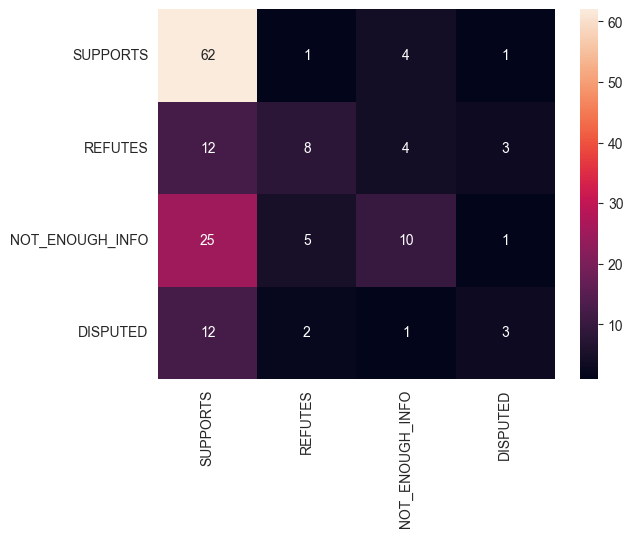

In [96]:

from peft import LoraConfig, get_peft_model, TaskType
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

import re
import json
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    pipeline,
    RobertaTokenizer, RobertaModel
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
import lightgbm as lgb

from imblearn.over_sampling import SMOTE


MODEL_NAME    = "roberta-base"
ZS_MODEL      = "microsoft/deberta-v2-xlarge-mnli"
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ZS_DEVICE_IDX = 0 if DEVICE.type=="cuda" else -1
LABEL_MAP     = {"SUPPORTS":0,"REFUTES":1,"NOT_ENOUGH_INFO":2,"DISPUTED":3}
ID_TO_LABEL   = {v:k for k,v in LABEL_MAP.items()}
candidate_labels = list(LABEL_MAP.keys())

print(f": {DEVICE}, Zero-Shot on {ZS_MODEL} device {ZS_DEVICE_IDX}")
def train_peft_model(claims, evids, labels, epochs=3, batch_size=16):

    texts = [f"Claim: {c} Evidence: {' ; '.join(ev[:3])}" for c,ev in zip(claims,evids)]

    
    class TxtClsDataset(torch.utils.data.Dataset):
        def __init__(self, texts, labels, tokenizer):
            self.enc = tokenizer(
                texts, truncation=True, padding="max_length",
                max_length=256, return_tensors="pt"
            )
            self.labels = torch.tensor(labels, dtype=torch.long)
        def __len__(self):  return len(self.labels)
        def __getitem__(self, idx):
            item = {k:v[idx] for k,v in self.enc.items()}
            item["labels"] = self.labels[idx]
            return item

    tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
    base_cls   = RobertaForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=len(LABEL_MAP)
    )

   
    lora_cfg = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=8, lora_alpha=16, lora_dropout=0,
        target_modules=["query","value"]  
    )
    peft_model = get_peft_model(base_cls, lora_cfg).to(DEVICE)

    # 4. Trainer
    ds = TxtClsDataset(texts, labels, tokenizer)
    args = TrainingArguments(
        output_dir="./lora_out",
        per_device_train_batch_size=batch_size,
        num_train_epochs=epochs,
        learning_rate=2e-4,
        logging_strategy="epoch",
        save_strategy="no",
        report_to="none"
    )
    tr = Trainer(model=peft_model, args=args, train_dataset=ds)
    tr.train()
    peft_model.eval()
    return tokenizer, peft_model

@torch.no_grad()
def get_lora_probs(tokenizer, peft_model, claim, evids):
    txt = f"Claim: {claim} Evidence: {' ; '.join(evids[:3])}"
    enc = tokenizer(txt, truncation=True, padding="max_length",
                    max_length=256, return_tensors="pt").to(DEVICE)
    logits = peft_model(**enc).logits.softmax(dim=-1).squeeze().cpu().numpy()
    return logits      # shape (4,)

def apply_rules(claim, evidences, manual_features):
    mf = np.atleast_1d(manual_features)
    cl, tx = claim.lower(), " ".join(evidences).lower()
   
    has_conflict = mf[-3] if len(mf)>2 else 0
    support_e = mf[-5] if len(mf)>4 else 0
    refute_e  = mf[-4] if len(mf)>3 else 0
    
    cw, ew = set(re.findall(r"\b\w+\b",cl)), set(re.findall(r"\b\w+\b",tx))
    overlap = len(cw & ew) / (len(cw) or 1)
   
    supp_terms = ["support","confirm","prove","demonstrate","show","evidence","agree"]
    refu_terms = ["refute","contradict","disagree","inconsistent","disprove","counter"]
    disp_terms = ["debate","controversy","disputed","contrary","conflict","argue"]
    unct_terms = ["may","might","could","possibly","perhaps","unclear","uncertain"]
    sc = sum(tx.count(t) for t in supp_terms)
    rc = sum(tx.count(t) for t in refu_terms)
    dc = sum(tx.count(t) for t in disp_terms)
    uc = sum(tx.count(t) for t in unct_terms)
   
    scores = {cls:0.0 for cls in LABEL_MAP.values()}
    if overlap<0.15 or (uc>sc+rc):
        scores[LABEL_MAP["NOT_ENOUGH_INFO"]]+=0.8
    if has_conflict==1 or dc>=2 or (support_e>0 and refute_e>0):
        scores[LABEL_MAP["DISPUTED"]]+=0.7
    if sc>rc+2 and support_e>0 and refute_e==0:
        scores[LABEL_MAP["SUPPORTS"]]+=0.6
    if rc>sc+2 and refute_e>0 and support_e==0:
        scores[LABEL_MAP["REFUTES"]]+=0.6
    max_score = max(scores.values())
    if max_score>0.5:
        return max(scores.items(), key=lambda x:x[1])[0], max_score
    return None, 0.0


def prepare_data(df, evid_dict):
    claims = df["claim_text"].tolist()
    evids  = [[evid_dict[e] for e in evs] for evs in df["evid_ids"]]
    labels = df["label_id"].tolist() if "label_id" in df.columns else None
    return claims, evids, labels


def apply_smote(X, y):

    print(f"initdistribut: {np.bincount(y)}")
    
    sampling_strategy = {
        LABEL_MAP["REFUTES"]: np.bincount(y).max(),
        LABEL_MAP["DISPUTED"]: np.bincount(y).max()
    }
    
    smote = SMOTE(
        sampling_strategy=sampling_strategy,
        random_state=42,
        k_neighbors=min(5, min(np.bincount(y)[LABEL_MAP["REFUTES"]]-1, 
                              np.bincount(y)[LABEL_MAP["DISPUTED"]]-1))
    )
    

    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    print(f"SMOTE: {np.bincount(y_resampled)}")
    return X_resampled, y_resampled


def extract_advanced_features(claims, evids, tokenizer, model):
    feats = []
    with torch.no_grad():
        for claim, ev_list in tqdm(zip(claims,evids), total=len(claims), desc="RoBERTa "):
            ci = tokenizer(claim, max_length=128, padding="max_length", truncation=True, return_tensors="pt").to(DEVICE)
            co = model(**ci).last_hidden_state[:,0,:].cpu().numpy().flatten()
            ev_text = " ".join(ev_list[:3])
            ei = tokenizer(ev_text, max_length=384, padding="max_length", truncation=True, return_tensors="pt").to(DEVICE)
            eo = model(**ei).last_hidden_state[:,0,:].cpu().numpy().flatten()
            feats.append(np.concatenate([co, eo]))
    return np.vstack(feats)


def extract_manual_features(claims, evids):
    feats = []
    keywords = {
        "support":["support","confirm","prove","demonstrate","show","evidence","agree","consistent"],
        "refute" :["refute","contradict","disagree","inconsistent","disprove","counter","false","incorrect"],
        "dispute":["debate","controversy","disputed","contrary","conflict","argue"],
        "climate":["climate","warming","temperature","carbon","co2","emission","greenhouse"]
    }
    climate_terms = keywords["climate"] + ["global warming","carbon dioxide","ice","sea level","atmosphere"]
    for claim, ev_list in tqdm(zip(claims,evids), total=len(claims), desc="manual feature"):
        cl, tx = claim.lower(), " ".join(ev_list).lower()
        vec = [len(cl), len(tx), len(ev_list)]
        cw, ew = set(re.findall(r"\b\w+\b",cl)), set(re.findall(r"\b\w+\b",tx))
        over = len(cw & ew)
        vec += [over, over/(len(cw) or 1)]
        for ws in keywords.values():
            vec.append(sum(cl.count(w) for w in ws))
            vec.append(sum(tx.count(w) for w in ws))
        se = sum(1 for ev in ev_list if sum(ev.lower().count(w) for w in keywords["support"]) >
                                sum(ev.lower().count(w) for w in keywords["refute"]))
        re_ = sum(1 for ev in ev_list if sum(ev.lower().count(w) for w in keywords["refute"]) >
                                sum(ev.lower().count(w) for w in keywords["support"]))
        vec += [se, re_, int(se>0 and re_>0)]
        vec.append(abs(se/len(ev_list)-re_/len(ev_list)) if len(ev_list)>1 else 1.0)
        vec.append(sum(term in cl for term in climate_terms))
        vec.append(sum(term in tx for term in climate_terms))
        feats.append(vec)
    return np.array(feats, dtype=np.float32)


zs_pipe = pipeline(
    "zero-shot-classification",
    model=ZS_MODEL,
    device=ZS_DEVICE_IDX
)
def extract_zs_features(claims, evids, zs_pipe, labels, batch_size=16):
    feats = []
    for i in tqdm(range(0, len(claims), batch_size), desc="Zero-Shot "):
        batch_c = claims[i:i+batch_size]
        batch_e = evids[i:i+batch_size]
        texts   = [f"Claim: {c} Evidence: " + " ; ".join(ev[:3]) for c,ev in zip(batch_c,batch_e)]
        outs    = zs_pipe(texts, labels)
        for out in outs:
            d = dict(zip(out["labels"], out["scores"]))
            feats.append([d[l] for l in labels])
    return np.array(feats, dtype=np.float32)


from sklearn.utils.class_weight import compute_class_weight

def train_advanced_ensemble(Xb, Xm, Xzs, y, lora_tok, lora_model):

    scaler = StandardScaler().fit(Xm)
    Xm_s   = scaler.transform(Xm)


    Xc     = np.hstack([Xb, Xm_s, Xzs])


    classes      = np.unique(y)
    cw_array     = compute_class_weight("balanced", classes=classes, y=y)
    class_weights = dict(zip(classes, cw_array))

    sample_weight = np.array([class_weights[yy] for yy in y])


    xgb_b = xgb.XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        objective="multi:softprob", num_class=4,
        subsample=0.8, colsample_bytree=0.8, tree_method="hist",
        random_state=42
    )
    xgb_b.fit(Xb, y, sample_weight=sample_weight)


    lgb_m = lgb.LGBMClassifier(
        n_estimators=300, max_depth=7, learning_rate=0.05,
        num_leaves=64, subsample=0.8, colsample_bytree=0.8,
        class_weight=class_weights, random_state=42
    )
    lgb_m.fit(Xm_s, y)


    min_w = sample_weight.min()
    counts = np.round(sample_weight / min_w).astype(int)
    
 
    Xc_rep = np.vstack([
        np.repeat(Xc[i:i+1], counts[i], axis=0)
        for i in range(len(y))
    ])
    y_rep = np.hstack([
        np.repeat(y[i], counts[i])
        for i in range(len(y))
    ])
    

    mlp = MLPClassifier(
        hidden_layer_sizes=(512,256,128),
        activation="relu",
        solver="adam",
        max_iter=300,
        random_state=42
    )
    mlp.fit(Xc_rep, y_rep)




    xgb_m = xgb.XGBClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        subsample=0.7, colsample_bytree=0.7,
        objective="multi:softprob", num_class=4,
        random_state=43
    )
    xgb_m.fit(Xm_s, y, sample_weight=sample_weight)


    bases = [
        ("lgb", lgb.LGBMClassifier(
            n_estimators=100, random_state=42,
            class_weight=class_weights
        )),
        ("xgb", xgb.XGBClassifier(
            n_estimators=100, random_state=42
        ))
    ]
    meta  = LogisticRegression(
        C=1.0, class_weight=class_weights,
        max_iter=1000, random_state=42
    )
    stack = StackingClassifier(
        estimators=bases,
        final_estimator=meta,
        cv=3, n_jobs=-1
    )

    stack.fit(Xc, y, sample_weight=sample_weight)


    return {
        "xgb_b"      : xgb_b,
        "lgb_m"      : lgb_m,
        "mlp"        : mlp,
        "xgb_m"      : xgb_m,
        "stack"      : stack,
        "scaler"     : scaler,
        "lora_tok"   : lora_tok,
        "lora_model" : lora_model
    }



def advanced_hybrid_predict(models,
                            claim: str,
                            evs: list[str],
                            xb: np.ndarray,
                            xm: np.ndarray,
                            xzs: np.ndarray) -> int:


    rule_pred, rule_conf = apply_rules(claim, evs, xm)

  
    xb_   = xb.reshape(1, -1)
    xm_s  = models["scaler"].transform(xm.reshape(1, -1))
    xc    = np.hstack([xb_, xm_s, xzs.reshape(1, -1)])

    p1 = models["xgb_b"].predict_proba(xb_)[0]
    p2 = models["lgb_m"].predict_proba(xm_s)[0]
    p3 = models["mlp"].predict_proba(xc)[0]
    p4 = models["xgb_m"].predict_proba(xm_s)[0]
    p_lora = get_lora_probs(models["lora_tok"],
                            models["lora_model"],
                            claim, evs)


    votes: dict[int, float] = {}

    branch_list = [
        (p1, "xgb_b", 1.2),
        (p2, "lgb_m", 1.0),
        (p3, "mlp",   1.1),
        (p4, "xgb_m", 0.9),
        (p_lora, "lora", 1.0),
    ]
    for probs, name, wt in branch_list:
        cls = probs.argmax()
        votes[cls] = votes.get(cls, 0.0) + probs.max() * wt

    if models.get("stack") is not None:
        try:
            p5 = models["stack"].predict_proba(xc)[0]
            cls5 = p5.argmax()
            votes[cls5] = votes.get(cls5, 0.0) + p5.max() * 1.6
        except Exception:
            pass


    if rule_pred is not None:
        votes[rule_pred] = votes.get(rule_pred, 0.0) + rule_conf * 2.0


    for cls in (LABEL_MAP["DISPUTED"], LABEL_MAP["REFUTES"]):
        if cls in votes:
            votes[cls] *= 1.3

    return max(votes.items(), key=lambda kv: kv[1])[0]





def main(df_train: pd.DataFrame,
         df_dev  : pd.DataFrame,
         evid_dict: dict[str, str],
         lora_epochs: int = 3,
         lora_batch : int = 16):
    tr_c, tr_e, tr_y = prepare_data(df_train, evid_dict)
    dv_c, dv_e, dv_y = prepare_data(df_dev ,  evid_dict)


    lora_tok, lora_mdl = train_peft_model(
        tr_c, tr_e, tr_y,
        epochs      = lora_epochs,
        batch_size  = lora_batch
    )


    tok = RobertaTokenizer.from_pretrained(MODEL_NAME)
    mdl = RobertaModel.from_pretrained(MODEL_NAME).to(DEVICE).eval()

    Xb_tr  = extract_advanced_features(tr_c, tr_e, tok, mdl)
    Xm_tr  = extract_manual_features (tr_c, tr_e)
    Xzs_tr = extract_zs_features     (tr_c, tr_e, zs_pipe, candidate_labels)

    Xb_dv  = extract_advanced_features(dv_c, dv_e, tok, mdl)
    Xm_dv  = extract_manual_features (dv_c, dv_e)
    Xzs_dv = extract_zs_features     (dv_c, dv_e, zs_pipe, candidate_labels)

 
    print("\nRoBERTa ")
    Xb_tr_os, y_tr_os = apply_smote(Xb_tr, tr_y)

    print("\nManual ")
    Xm_tr_os, _       = apply_smote(Xm_tr, tr_y)

    print("\nZero‑Shot ")
    Xzs_tr_os, _      = apply_smote(Xzs_tr, tr_y)

    
    models = train_advanced_ensemble(
        Xb_tr_os, Xm_tr_os, Xzs_tr_os, y_tr_os,
        lora_tok, lora_mdl    
    )

    
    preds = []
    for c, ev, xb, xm, xzs in tqdm(
        zip(dv_c, dv_e, Xb_dv, Xm_dv, Xzs_dv),
        total=len(dv_c), desc="Hybrid Predict"
    ):
        preds.append(
            advanced_hybrid_predict(models, c, ev, xb, xm, xzs)
        )

   
    acc = (np.array(preds) == dv_y).mean()
    print(f"Dev accuracy: {acc:.4f}")
    print(classification_report(dv_y, preds, target_names=candidate_labels))

    cm = confusion_matrix(dv_y, preds)
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=candidate_labels,
                yticklabels=candidate_labels)
    plt.show()

 
    output = {
        row["claim_id"]: {
            "claim_label": ID_TO_LABEL[pred],
            "evidences"  : row["evid_ids"]
        }
        for pred, row in zip(preds, df_dev.to_dict("records"))
    }
    with open("dev-predictions.json", "w") as f:
        json.dump(output, f, indent=2, ensure_ascii=False)

    return models, preds



models, predictions = main(df_train, df_val, evid_dict)


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*